# 5.SQL and Dataframes

References:

* Spark-SQL, <https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes>


# 5.1  Example Walkthrough
Follow the Spark SQL and Dataframes Examples below!

### Initialize PySpark

First, we use the findspark package to initialize PySpark.

In [1]:
import os, sys
os.chdir(os.path.join(os.environ["HOME"], "exercise-students-2020/05_SQL"))
%pwd

'/home/jupyter-filipiuk-12151613/exercise-students-2020/05_SQL'

In [2]:
# Initialize PySpark
import os, sys
APP_NAME = "PySpark Lecture"
SPARK_MASTER="local[1]"
import pyspark
import pyspark.sql
from pyspark.sql import Row
conf=pyspark.SparkConf()
conf=pyspark.SparkConf().setAppName(APP_NAME).set("spark.local.dir", os.path.join(os.getcwd(), "tmp"))
sc = pyspark.SparkContext(master=SPARK_MASTER, conf=conf)
spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initiated...")

PySpark initiated...


### Hello, World!

Loading data, mapping it and collecting the records into RAM...

In [3]:
# Load the text file using the SparkContext
csv_lines = sc.textFile("../data/example.csv")

# Map the data to split the lines into a list
data = csv_lines.map(lambda line: line.split(","))

# Collect the dataset into local RAM
data.collect()

[['Russell Jurney', 'Relato', 'CEO'],
 ['Florian Liebert', 'Mesosphere', 'CEO'],
 ['Don Brown', 'Rocana', 'CIO'],
 ['Steve Jobs', 'Apple', 'CEO'],
 ['Donald Trump', 'The Trump Organization', 'CEO'],
 ['Russell Jurney', 'Data Syndrome', 'Principal Consultant']]

### Creating Rows

Creating `pyspark.sql.Rows` out of your data so you can create DataFrames...

In [4]:
# Convert the CSV into a pyspark.sql.Row
def csv_to_row(line):
    parts = line.split(",")
    row = Row(
      name=parts[0],
      company=parts[1],
      title=parts[2]
    )
    return row

# Apply the function to get rows in an RDD
rows = csv_lines.map(csv_to_row)

### Creating DataFrames from RDDs

Using the `RDD.toDF()` method to create a dataframe, registering the `DataFrame` as a temporary table with Spark SQL, and counting the jobs per person using Spark SQL.

In [5]:
# Convert to a pyspark.sql.DataFrame
rows_df = rows.toDF()
rows_df.take(5)

[Row(company='Relato', name='Russell Jurney', title='CEO'),
 Row(company='Mesosphere', name='Florian Liebert', title='CEO'),
 Row(company='Rocana', name='Don Brown', title='CIO'),
 Row(company='Apple', name='Steve Jobs', title='CEO'),
 Row(company='The Trump Organization', name='Donald Trump', title='CEO')]

In [6]:
# Register the DataFrame for Spark SQL
rows_df.registerTempTable("executives")

# Generate a new DataFrame with SQL using the SparkSession
job_counts = spark.sql("""
SELECT
  name,
  COUNT(*) AS total
  FROM executives
  GROUP BY name
""")
job_counts.show()

# Go back to an RDD
job_counts.rdd.collect()

+---------------+-----+
|           name|total|
+---------------+-----+
|   Donald Trump|    1|
|Florian Liebert|    1|
|      Don Brown|    1|
| Russell Jurney|    2|
|     Steve Jobs|    1|
+---------------+-----+



[Row(name='Donald Trump', total=1),
 Row(name='Florian Liebert', total=1),
 Row(name='Don Brown', total=1),
 Row(name='Russell Jurney', total=2),
 Row(name='Steve Jobs', total=1)]

# 5.2-5.9 NASA DataSet

5.2 Create a Spark-SQL table with fields for IP/Host and Response Code from the NASA Log file! 

In [7]:
!tail -n5 /opt/data/nasa/NASA_access_log_Jul95

163.205.53.14 - - [28/Jul/1995:13:32:23 -0400] "GET /images/KSC-logosmall.gif HTTP/1.0" 200 1204
tiger2.ocs.lsu.edu - - [28/Jul/1995:13:32:23 -0400] "GET /shuttle/missions/missions.html HTTP/1.0" 200 8677
199.0.2.27 - - [28/Jul/1995:13:32:23 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 200 5866
tornado.umd.edu - - [28/Jul/1995:13:32:25 -0400] "GET /shuttle/missions/sts-74/sts-74-patch-small.gif HTTP/1.0" 200 5494
alyssa.p

In [8]:
# Load the text file using the SparkContext
nasa_lines = sc.textFile("/opt/data/nasa/NASA_access_log_Jul95")

In [9]:
# Convert the CSV into a pyspark.sql.Row
def nasa_to_row(line):
    parts = line.split(" ")
    row = Row(
      host=parts[0],
      res=parts[-2]
    )
    return row

# Apply the function to get rows in an RDD
nasa_rows = nasa_lines.filter(lambda x: '- -' in x).map(nasa_to_row)

In [10]:
# Convert to a pyspark.sql.DataFrame
nasa_df = nasa_rows.toDF()

In [11]:
nasa_df.take(5)

[Row(host='199.72.81.55', res='200'),
 Row(host='unicomp6.unicomp.net', res='200'),
 Row(host='199.120.110.21', res='200'),
 Row(host='burger.letters.com', res='304'),
 Row(host='199.120.110.21', res='200')]

5.3 Run an SQL query that outputs the number of occurrences of each HTTP response code!

In [12]:
# Register the DataFrame for Spark SQL
nasa_df.registerTempTable("nasalogs")

# Generate a new DataFrame with SQL using the SparkSession
res_counts = spark.sql("""
SELECT
  res,
  COUNT(*) AS total
  FROM nasalogs
  GROUP BY res
""")
res_counts.show()

+---+-------+
|res|  total|
+---+-------+
|200|1701534|
|302|  46573|
|501|     14|
|404|  10845|
|403|     54|
|500|     62|
|304| 132627|
|400|      5|
+---+-------+



5.4 Cachen Sie den Dataframe und führen Sie dieselbe Query nochmals aus! Messen Sie die Laufzeit für das Cachen und für die Ausführungszeit der Query!

In [13]:
from time import time

In [14]:
cstart = time()
nasa_df.cache().collect()
cend = time()
print('Cache runtime: %.3f' % (cend - cstart))

Cache runtime: 21.747


In [15]:
qstart = time()
res_counts = spark.sql("""
SELECT
  res,
  COUNT(*) AS total
  FROM nasalogs
  GROUP BY res
""")

res_counts.show()
qend = time()
print('Query runtime: %.3f' % (qend - qstart))

+---+-------+
|res|  total|
+---+-------+
|200|1701534|
|302|  46573|
|501|     14|
|404|  10845|
|403|     54|
|500|     62|
|304| 132627|
|400|      5|
+---+-------+

Query runtime: 1.209


5.5. Implement the same Query using the Dataframe API!

In [15]:
nasa_df.take(3)

[Row(host='199.72.81.55', res='200'),
 Row(host='unicomp6.unicomp.net', res='200'),
 Row(host='199.120.110.21', res='200')]

In [16]:
nasa_df.groupBy('res').count().show()

+---+-------+
|res|  count|
+---+-------+
|200|1701534|
|302|  46573|
|501|     14|
|404|  10845|
|403|     54|
|500|     62|
|304| 132627|
|400|      5|
+---+-------+



5.6 Führen Sie diesselbe Query mit/ohne Cache und 8, 16 Cores aus! Dokumentieren und erklären Sie das Ergebnis!

In [47]:
def evaluate_num_cores(core = 8, cache = False):
    if cache:
        nasa_df.cache().count()
    else:
        nasa_df.unpersist()
    spark.sparkContext.master = "local[{0}]".format(core)
    start = time()
    nasa_df.groupBy('res').count().show()
    return time() - start

In [48]:
print('Elapsed time: %.3f s' % evaluate_num_cores(8, cache = False))

+---+-------+
|res|  count|
+---+-------+
|200|1701534|
|302|  46573|
|501|     14|
|404|  10845|
|403|     54|
|500|     62|
|304| 132627|
|400|      5|
+---+-------+

Elapsed time: 12.126 s


In [49]:
print('Elapsed time: %.3f s' % evaluate_num_cores(8, cache = True))

+---+-------+
|res|  count|
+---+-------+
|200|1701534|
|302|  46573|
|501|     14|
|404|  10845|
|403|     54|
|500|     62|
|304| 132627|
|400|      5|
+---+-------+

Elapsed time: 0.976 s


In [50]:
print('Elapsed time: %.3f s' % evaluate_num_cores(16, cache = False))

+---+-------+
|res|  count|
+---+-------+
|200|1701534|
|302|  46573|
|501|     14|
|404|  10845|
|403|     54|
|500|     62|
|304| 132627|
|400|      5|
+---+-------+

Elapsed time: 12.088 s


In [51]:
print('Elapsed time: %.3f s' % evaluate_num_cores(16, cache = True))

+---+-------+
|res|  count|
+---+-------+
|200|1701534|
|302|  46573|
|501|     14|
|404|  10845|
|403|     54|
|500|     62|
|304| 132627|
|400|      5|
+---+-------+

Elapsed time: 0.833 s


**Explanation**  
independently of number of cores used the execution time of counting the occurence of each resonse code  
is roughly the same and is only depending on the fact whether the data is cached or not!

In [52]:
spark

5.7 Performance Analysis: 
* Create RDDs with 2x, 4x, 8x and 16x of the size of the NASA log dataset! Persist the dataset in the Spark Cache! Use an appropriate number of cores (e.g. 8 or 16)!
* Measure and plot the response times for all datasets using a constant number of cores!
* Plot the results!
* Explain the results!



In [53]:
def oversample(n):
    nasa_lines = sc.textFile("/opt/data/nasa/NASA_access_log_Jul95")\
    .filter(lambda x: '- -' in x)\
    .flatMap(lambda x: [x]*n)\
    .map(nasa_to_row)
    return nasa_lines.toDF()

In [54]:
spark.sparkContext.master = "local[16]"

In [55]:
oversamples = []
for x in (2**p for p in range(1, 5)):
    tmp = oversample(x)
    tmp.cache().count()
    oversamples.append(tmp)

In [56]:
measures = {}
for i, df in enumerate(oversamples):
    start = time()
    df.groupBy('res').count().collect()
    end = time()
    measures[2**(i + 1)] = end - start

In [57]:
measures

{2: 0.9656085968017578,
 4: 1.341430902481079,
 8: 1.9388251304626465,
 16: 3.289229154586792}

In [58]:
import matplotlib.pyplot as plt

<BarContainer object of 4 artists>

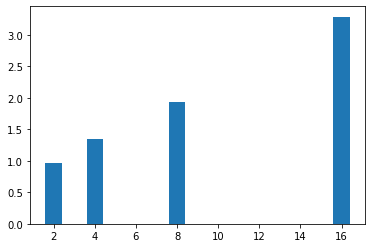

In [59]:
plt.bar(measures.keys(), measures.values())

In [60]:
spark.sparkContext.master = "local[1]"

In [61]:
measures = {}
for i, df in enumerate(oversamples):
    start = time()
    df.groupBy('res').count().collect()
    end = time()
    measures[2**(i + 1)] = end - start

<BarContainer object of 4 artists>

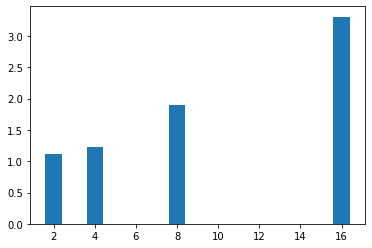

In [62]:
plt.bar(measures.keys(), measures.values())

**Explanation**

@Michał: what do u think?

5.8 Strong Scaling

  * **Measure the runtime for the query for 1, 2, 4, 8 and 16 cores for 1x and 16x datasets!** Datasets cached in Memory!
  * Compute the speedup and efficiency!
  * Plot the responses!
  * Explain the results!

In [63]:
oversample_1 = oversample(1).cache()
oversample_1.count()
oversample_16 = oversample(16).cache()
oversample_16.count()

30267424

In [64]:
measures = {1:{}, 16:{}}
for x in [2**x for x in range(5)]:
    for y in [(1,oversample_1),(16,oversample_16)]:
        start = time()
        y[1].groupBy('res').count().collect()
        end = time()
        measures[y[0]][str(x) + " core"] = end - start

In [65]:
measures

{1: {'1 core': 0.754523515701294,
  '2 core': 0.7184219360351562,
  '4 core': 0.7485907077789307,
  '8 core': 0.7334268093109131,
  '16 core': 0.7739908695220947},
 16: {'1 core': 3.3211138248443604,
  '2 core': 3.3151230812072754,
  '4 core': 3.2508134841918945,
  '8 core': 3.316906452178955,
  '16 core': 3.22495698928833}}

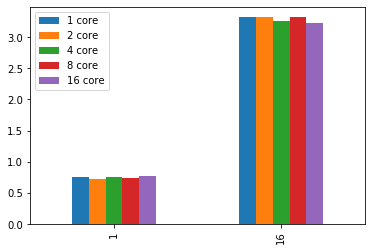

In [66]:
import pandas as pd
pd.DataFrame(measures).T.plot.bar()

WIP below

In [51]:
speedup = [ for k in measures]

SyntaxError: invalid syntax (<ipython-input-51-b2b7a17df75b>, line 1)

In [48]:
oversample_1.groupBy('res').count().collect()

[Row(res='200', count=1701534),
 Row(res='302', count=46573),
 Row(res='501', count=14),
 Row(res='404', count=10845),
 Row(res='403', count=54),
 Row(res='500', count=62),
 Row(res='304', count=132627),
 Row(res='400', count=5)]